# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Connection to your drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

DATA_DIR =  '/content/gdrive/MyDrive/teaching/pizza'

Mounted at /content/gdrive/


## Useful libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Thu Jan 25 06:29:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Managing data

### Load and uncompress the archive on Gdrive (rather than on your own desktop)
Uncomment the following line to do it.

In [ ]:
# !wget -P /content/gdrive/MyDrive/teaching/pizza/ http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip
# !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/teaching/pizza/'
# !unzip '/content/gdrive/MyDrive/teaching/pizza/pizzaGANsyntheticdata.zip.1' -d '/content/gdrive/MyDrive/teaching/pizza/'

### Read data

and build the train and test dataset

In [26]:
y_all = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/train/trainLabels.txt'))
x_all = np.arange(y_all.shape[0])

# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

ntrain = x_train.shape[0]
ndim = y_train.shape[1]

print("Les données sont de dimension {:d}".format(ndim))
print("Le nombre de données d'apprentissage est {:d}".format(ntrain))

y_test = np.loadtxt(os.path.join(DATA_DIR, 'syntheticDataset/test/testLabels.txt'))
x_test = np.arange(y_test.shape[0])

print("Le nombre de donnée de test est {:d}".format(x_test.shape[0]))

topping_names = ["bacon", "basil", 'broccoli', "mushrooms", "olives", "onions", "pepperoni", "peppers", "pineapple", "tomatoes"] # taken from the paper
print(y_train)

Les données sont de dimension 10
Le nombre de données d'apprentissage est 3976
Le nombre de donnée de test est 497
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 1. 0. 1.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]]


Frequency of Each Topping in the Dataset


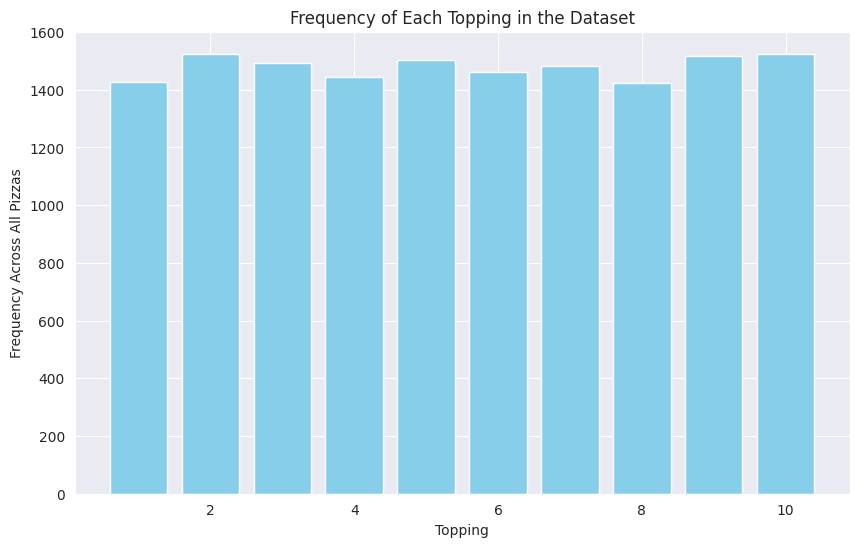

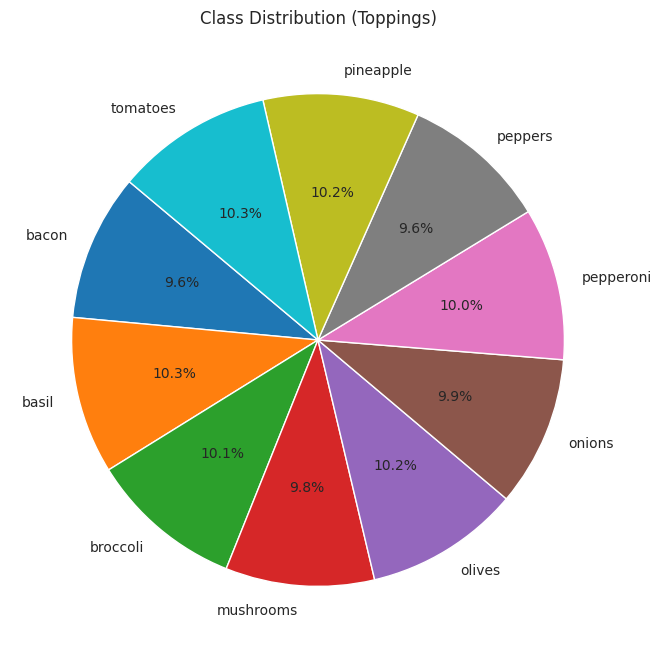

In [4]:
topping_frequency = np.sum(y_all, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(topping_frequency)+1), topping_frequency, color='skyblue', width=0.8)

# Labeling
plt.xlabel('Topping')
plt.ylabel('Frequency Across All Pizzas')
plt.title('Frequency of Each Topping in the Dataset')

# Display the plot
plt.show()

class_distribution = np.sum(y_all, axis=0)

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=topping_names, autopct='%1.1f%%', startangle=140)

# Labeling
plt.title('Class Distribution (Toppings)')

# Display the plot
plt.show()

Class Distribution in Train and Test Sets

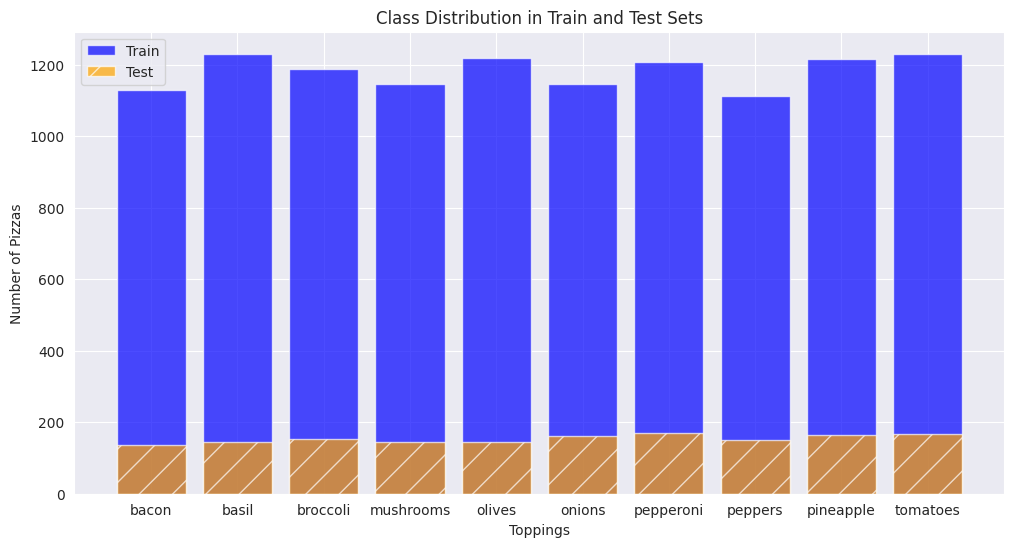

In [5]:
# Calculate class distribution
class_distribution_train = np.sum(y_train, axis=0)
class_distribution_test = np.sum(y_test, axis=0)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(topping_names, class_distribution_train, color='blue', alpha=0.7, label='Train')
plt.bar(topping_names, class_distribution_test, color='orange', alpha=0.7, label='Test', hatch='/')

# Labeling
plt.xlabel('Toppings')
plt.ylabel('Number of Pizzas')
plt.title('Class Distribution in Train and Test Sets')
plt.legend()

# Display the bar chart
plt.show()

### Display one sample image

0046.png


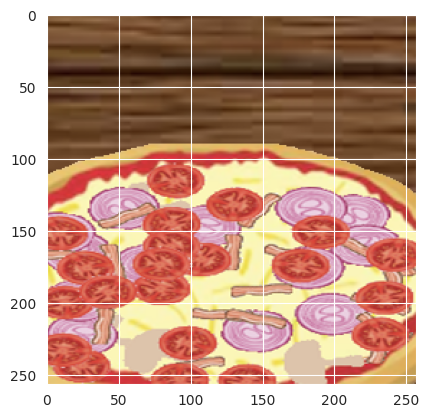

In [6]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)

img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### Store train images in memory

This should make learning faster.

In [7]:
train_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

### Dataset class

In [8]:
class myDataset(Dataset):
    """Pizza dataset"""

    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data

    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y

    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In [9]:
batch_size = 25

input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])

kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img_data_train = img_all[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)


### Visualize data loader

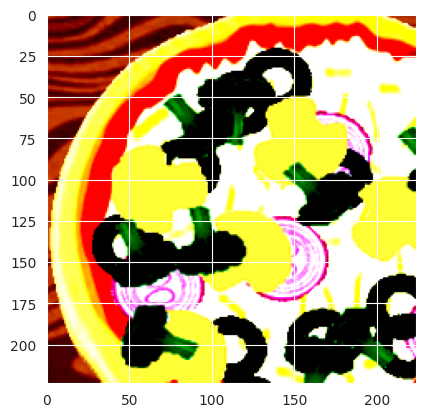

torch.Size([25, 3, 224, 224])


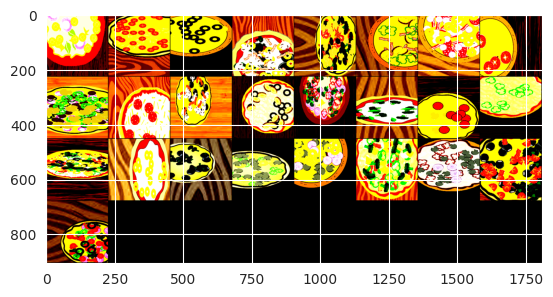

In [10]:
# Show dataset sample
x,y = test_set_raw[45]
#print(x,y)

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))


### Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


### Simple network definition

An elementary convolutional network with input datasize of 32x32.

If you want to  use it, you will need to modify the dataloader.

In [11]:
# network class
class SimpleCNN(nn.Module):
    # Network requires 32x32 input images
    def __init__(self, nlabel=10):
        super(SimpleCNN, self).__init__()
        self.nlabel = nlabel

        # define here the convolutions and linear layers
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)

        # dynamically calculate the input size for the linear layer
        x = torch.randn(1, 3, 224, 224)
        self._conv_size(x)

        self.lin1 = nn.Linear(self.conv_out_size, 128)
        self.lin2 = nn.Linear(128, self.nlabel)

    def forward(self, x):
        # 32x32

        # define here the forward pass
        x1 = self.conv1(x)
        x1r = F.relu(x1)
        x1p = F.max_pool2d(x1r, 2)

        # 16x16
        x2 = self.conv2(x1p)
        x2r = F.relu(x2)
        x2p = F.max_pool2d(x2r, 2)

        # 8x8
        x3 = self.conv3(x2p)
        x3r = F.relu(x3)
        x3p = F.max_pool2d(x3r, 2)

        # 4x4
        y0 = x3p.view(x3p.size(0), -1)

        y1 = self.lin1(y0)
        y1r = F.relu(y1)
        y2 = self.lin2(y1r)

        return y2

    def _conv_size(self, x):
        # Helper function to calculate the output size of the last convolutional layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        self.conv_out_size = x.view(x.size(0), -1).size(1)


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):
    # Lists for saving accuracies and losses
    train_perf = []
    val_perf = []
    train_losses = []
    val_losses = []

    # Threshold for binary classification (if Sigmoid is not used in the last layer)
    threshold = 0.5
    total_step = len(valloader)

    # Iterate over epochs
    for epoch in range(num_epochs):
        print(f"Epoch ({epoch + 1}/{num_epochs})")

        # Set the model to training mode
        model.train()
        train_perf_for_epoch = np.zeros((1, nlabel))

        # Training loop
        losses = []
        for inputs, targets in tqdm(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert to float32 if needed
            outputs = outputs.to(torch.float32)
            targets = targets.to(torch.float32)

            # Calculate loss
            loss = criterion(outputs, targets)
            losses.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate training accuracy
            outputs_np = outputs.cpu().detach().numpy()
            targets_np = targets.cpu().detach().numpy()
            predictions = (outputs_np > threshold)
            train_perf_for_epoch = train_perf_for_epoch + (targets_np == predictions).sum(axis=0)

        # Save training performance and losses
        train_perf.append(train_perf_for_epoch[0] / len(trainloader.dataset))
        train_losses.append(round(losses[-1], 4))

        # Display learning rate
        for param_group in optimizer.param_groups:
            print(f"Learning rate: {round(param_group['lr'], 6)}")

        print(f"Training performance mean: {round(train_perf[-1].mean(), 4)}")

        # Adjust learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step()

        # Validation loop
        val_perf_for_epoch = np.zeros((1, nlabel))

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            losses = []
            for inputs, targets in tqdm(valloader):
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass during validation
                outputs = model(inputs)

                # Convert to float32 if needed
                outputs = outputs.to(torch.float32)
                targets = targets.to(torch.float32)

                # Calculate validation loss
                loss_val = criterion(outputs, targets)
                losses.append(loss_val.item())

                # Calculate validation accuracy
                outputs_np = outputs.cpu().detach().numpy()
                targets_np = targets.cpu().detach().numpy()
                predictions = (outputs_np > threshold)
                val_perf_for_epoch = val_perf_for_epoch + (targets_np == predictions).sum(axis=0)

        # Save validation performance and losses
        val_perf.append(val_perf_for_epoch[0] / len(valloader.dataset))
        print(f"Validation loss: {round(losses[-1], 4)}")
        val_losses.append(round(losses[-1], 4))
        print(f"Validation performance mean: {round(val_perf[-1].mean(), 4)}\n")

    return model, train_perf, val_perf, train_losses, val_losses


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


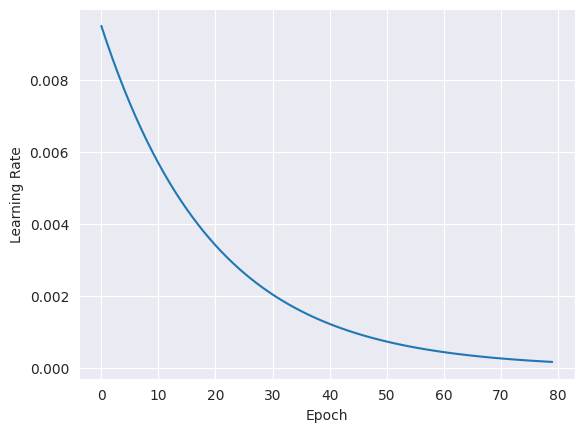

In [13]:
nlabel = y_all.shape[1]

network = SimpleCNN(nlabel = nlabel)

# Name of the network
tag = "simpleCNN"

# Hyperparamenets
max_learning_rate = 0.01
max_epoch = 20
batch_size = 64

# Data loaders
trainloader = train_dataloader
valloader = val_dataloader

# Read the last learned network (if stored)
# if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
#     print('Resume from last learning step')
#     network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=max_learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Visualize learning rate change during training

# List to store learning rates during training
learning_rates_history = []
num_epochs = 80

for epoch in range(num_epochs):
    scheduler.step()

    # Store learning rate for visualization
    learning_rates_history.append(optimizer.param_groups[0]["lr"])

plt.plot(range(num_epochs), learning_rates_history)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

Learning

Training the model:
Epoch (1/20)


100%|██████████| 160/160 [00:12<00:00, 13.33it/s]


Learning rate: 5.9e-05
Training performance mean: 0.8653


100%|██████████| 40/40 [00:01<00:00, 26.38it/s]


Validation loss: 0.3897
Validation performance mean: 0.8326

Epoch (2/20)


100%|██████████| 160/160 [00:11<00:00, 13.48it/s]


Learning rate: 5.6e-05
Training performance mean: 0.8681


100%|██████████| 40/40 [00:01<00:00, 26.85it/s]


Validation loss: 0.3958
Validation performance mean: 0.8322

Epoch (3/20)


100%|██████████| 160/160 [00:11<00:00, 13.68it/s]


Learning rate: 5.3e-05
Training performance mean: 0.8704


100%|██████████| 40/40 [00:01<00:00, 26.44it/s]


Validation loss: 0.3908
Validation performance mean: 0.8337

Epoch (4/20)


100%|██████████| 160/160 [00:12<00:00, 12.72it/s]


Learning rate: 5.1e-05
Training performance mean: 0.8729


100%|██████████| 40/40 [00:01<00:00, 26.13it/s]


Validation loss: 0.3966
Validation performance mean: 0.8336

Epoch (5/20)


100%|██████████| 160/160 [00:11<00:00, 13.41it/s]


Learning rate: 4.8e-05
Training performance mean: 0.8751


100%|██████████| 40/40 [00:01<00:00, 25.81it/s]


Validation loss: 0.3854
Validation performance mean: 0.835

Epoch (6/20)


100%|██████████| 160/160 [00:12<00:00, 13.31it/s]


Learning rate: 4.6e-05
Training performance mean: 0.877


100%|██████████| 40/40 [00:01<00:00, 26.13it/s]


Validation loss: 0.3794
Validation performance mean: 0.8327

Epoch (7/20)


100%|██████████| 160/160 [00:12<00:00, 13.30it/s]


Learning rate: 4.4e-05
Training performance mean: 0.8799


100%|██████████| 40/40 [00:01<00:00, 26.53it/s]


Validation loss: 0.3888
Validation performance mean: 0.8347

Epoch (8/20)


100%|██████████| 160/160 [00:13<00:00, 12.24it/s]


Learning rate: 4.1e-05
Training performance mean: 0.8816


100%|██████████| 40/40 [00:01<00:00, 26.54it/s]


Validation loss: 0.3734
Validation performance mean: 0.8398

Epoch (9/20)


100%|██████████| 160/160 [00:11<00:00, 13.44it/s]


Learning rate: 3.9e-05
Training performance mean: 0.8828


100%|██████████| 40/40 [00:01<00:00, 26.35it/s]


Validation loss: 0.3771
Validation performance mean: 0.8366

Epoch (10/20)


100%|██████████| 160/160 [00:11<00:00, 13.38it/s]


Learning rate: 3.7e-05
Training performance mean: 0.8849


100%|██████████| 40/40 [00:01<00:00, 26.55it/s]


Validation loss: 0.3568
Validation performance mean: 0.8439

Epoch (11/20)


100%|██████████| 160/160 [00:12<00:00, 13.31it/s]


Learning rate: 3.5e-05
Training performance mean: 0.888


100%|██████████| 40/40 [00:01<00:00, 26.13it/s]


Validation loss: 0.3631
Validation performance mean: 0.8392

Epoch (12/20)


100%|██████████| 160/160 [00:12<00:00, 13.33it/s]


Learning rate: 3.4e-05
Training performance mean: 0.8877


100%|██████████| 40/40 [00:01<00:00, 25.79it/s]


Validation loss: 0.3688
Validation performance mean: 0.8393

Epoch (13/20)


100%|██████████| 160/160 [00:12<00:00, 13.24it/s]


Learning rate: 3.2e-05
Training performance mean: 0.8898


100%|██████████| 40/40 [00:01<00:00, 26.19it/s]


Validation loss: 0.3785
Validation performance mean: 0.8431

Epoch (14/20)


100%|██████████| 160/160 [00:11<00:00, 13.40it/s]


Learning rate: 3e-05
Training performance mean: 0.8923


100%|██████████| 40/40 [00:01<00:00, 26.62it/s]


Validation loss: 0.386
Validation performance mean: 0.8394

Epoch (15/20)


100%|██████████| 160/160 [00:12<00:00, 13.24it/s]


Learning rate: 2.9e-05
Training performance mean: 0.8934


100%|██████████| 40/40 [00:01<00:00, 26.20it/s]


Validation loss: 0.375
Validation performance mean: 0.8401

Epoch (16/20)


100%|██████████| 160/160 [00:11<00:00, 13.42it/s]


Learning rate: 2.7e-05
Training performance mean: 0.8925


100%|██████████| 40/40 [00:01<00:00, 26.49it/s]


Validation loss: 0.378
Validation performance mean: 0.8425

Epoch (17/20)


100%|██████████| 160/160 [00:12<00:00, 13.33it/s]


Learning rate: 2.6e-05
Training performance mean: 0.8953


100%|██████████| 40/40 [00:01<00:00, 25.62it/s]


Validation loss: 0.3689
Validation performance mean: 0.8427

Epoch (18/20)


100%|██████████| 160/160 [00:11<00:00, 13.36it/s]


Learning rate: 2.5e-05
Training performance mean: 0.8964


100%|██████████| 40/40 [00:01<00:00, 26.08it/s]


Validation loss: 0.3627
Validation performance mean: 0.8438

Epoch (19/20)


100%|██████████| 160/160 [00:12<00:00, 13.33it/s]


Learning rate: 2.4e-05
Training performance mean: 0.8979


100%|██████████| 40/40 [00:01<00:00, 26.00it/s]


Validation loss: 0.3602
Validation performance mean: 0.8432

Epoch (20/20)


100%|██████████| 160/160 [00:12<00:00, 13.24it/s]


Learning rate: 2.2e-05
Training performance mean: 0.8976


100%|██████████| 40/40 [00:01<00:00, 25.75it/s]


Validation loss: 0.3668
Validation performance mean: 0.8422



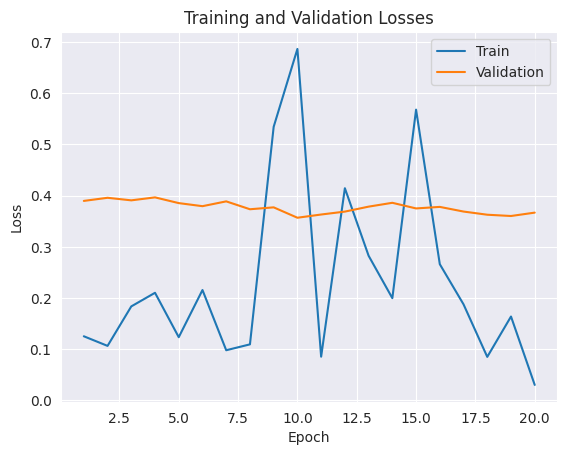


Train accuracies: [array([0.85890342, 0.76509054, 0.86041247, 0.97635815, 0.84532193,
       0.75100604, 0.91297787, 0.82746479, 0.86896378, 0.986167  ]), array([0.85714286, 0.76861167, 0.86544266, 0.97459759, 0.84783702,
       0.75729376, 0.91348089, 0.8332495 , 0.87575453, 0.98742455]), array([0.8584004 , 0.76408451, 0.87147887, 0.97635815, 0.85588531,
       0.76156942, 0.91624748, 0.84330986, 0.86996982, 0.98692153]), array([0.86343058, 0.77515091, 0.87047284, 0.97736419, 0.85814889,
       0.76307847, 0.92127767, 0.83450704, 0.87600604, 0.98993964]), array([0.86443662, 0.77590543, 0.88229376, 0.97912475, 0.86443662,
       0.76358149, 0.91825956, 0.83802817, 0.87525151, 0.98918511]), array([0.8667002 , 0.78294769, 0.88028169, 0.97862173, 0.86141851,
       0.76156942, 0.92027163, 0.85186117, 0.87650905, 0.99019115]), array([0.86996982, 0.78546278, 0.88480885, 0.97937626, 0.86217304,
       0.76911469, 0.92681087, 0.84657948, 0.88380282, 0.99044266]), array([0.87575453, 0.7867203

In [19]:
print("Training the model:")

# Train the model
learned_model, train_accuracy, test_accuracy, train_losses, val_losses = train_model_multilabel(
    network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch
)

# Save the trained model
torch.save(learned_model, os.path.join(img_path, f'network_{tag}.pth'))
network = learned_model

# Plotting the training and validation losses
plt.plot(range(1, max_epoch + 1), train_losses, label='Train')
plt.plot(range(1, max_epoch + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

print("\nTrain accuracies: {}".format(train_accuracy))
print("Test accuracies: {}".format(test_accuracy))
print("Train losses: {}".format(train_losses))

# Feature Extraction

### Compute deep features for images

Helper functions

In [20]:
def extract_feat(model, dataloader):
    feat = []
    for i, data in enumerate(tqdm(dataloader)):
        img, targets = data
        if device.type == 'cuda':
            img, targets = img.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = model(img)
        if device.type == 'cuda':
            feat.append(outputs.cpu().numpy().squeeze())
        else:
            feat.append(outputs.numpy().squeeze())
    return feat


def compute_feat(transform, feat_data_path):
  # Define dataset and dataloader for feat (no transformation)
  all_set_raw_feat = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform=transform)
  all_dataloader_feat = DataLoader(all_set_raw_feat, batch_size=200, shuffle=False, **kwargs)
  feat = extract_feat(model, all_dataloader_feat)

  # Convert to numpy arrays
  feat = np.array(np.concatenate(feat))

  # Save the features
  print("Storing image features in {}...".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)
  print("Done!")

  return feat

In [21]:
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
from torch.utils.data import DataLoader

resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

if device.type == 'cuda':
    resnext = resnext.cuda()

model = resnext

# Removes the last classification layer
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False


feat1_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat1_resnext.npz')
feat2_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat2_resnext.npz')

feat1 = []
feat2 = []

# Checks if feature already exist
if os.path.exists(feat1_data_path):
  print("Loading images with feature 1 from {}".format(feat1_data_path))
  feat1 = np.load(feat1_data_path)
  feat1 = feat1['img_feat']

# Doesn't exists => compute
else:
  print("Computing image feature 1")
  feat1 = compute_feat(val_transform, feat1_data_path)


# Checks if feature already exist
if os.path.exists(feat2_data_path):
  print("Loading images with feature 2 from {}".format(feat2_data_path))
  feat2 = np.load(feat2_data_path)
  feat2 = feat2['img_feat']

# Doesn't exists => compute
else:
  print("Computing image feature 2")
  feat2 = compute_feat(train_transform, feat2_data_path)


Loading images with feature 1 from /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/img_all_feat1_resnext.npz
Loading images with feature 2 from /content/gdrive/MyDrive/teaching/pizza/syntheticDataset/train/img_all_feat2_resnext.npz


In [50]:
# Concatenate feat1 and feat2
X = np.concatenate((feat1, feat2), axis = 0)
y = np.concatenate((y_all, y_all), axis = 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random Forest

In [45]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create a base classifier
base_classifier = RandomForestClassifier(random_state=42)

# Create MultiOutputClassifier
multi_output_classifier = MultiOutputClassifier(base_classifier)

# Train the classifier
multi_output_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_output_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

# The results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.11
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.28      0.43       571
           1       0.90      0.21      0.34       611
           2       0.89      0.12      0.20       582
           3       0.95      0.53      0.68       592
           4       0.81      0.11      0.20       615
           5       0.90      0.27      0.42       590
           6       0.92      0.50      0.65       595
           7       0.97      0.21      0.35       623
           8       0.96      0.31      0.47       594
           9       0.96      0.46      0.62       645

   micro avg       0.94      0.30      0.46      6018
   macro avg       0.92      0.30      0.44      6018
weighted avg       0.92      0.30      0.44      6018
 samples avg       0.96      0.33      0.41      6018



Confusion Matrix

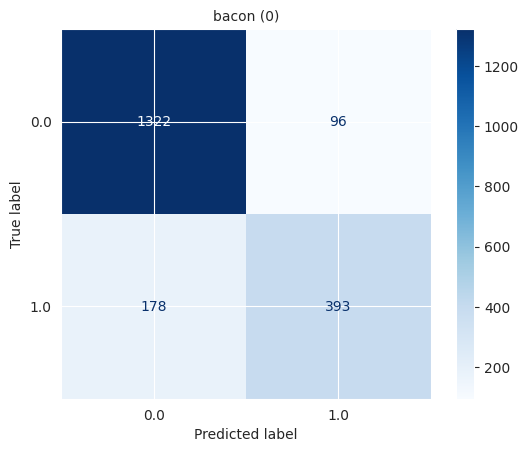

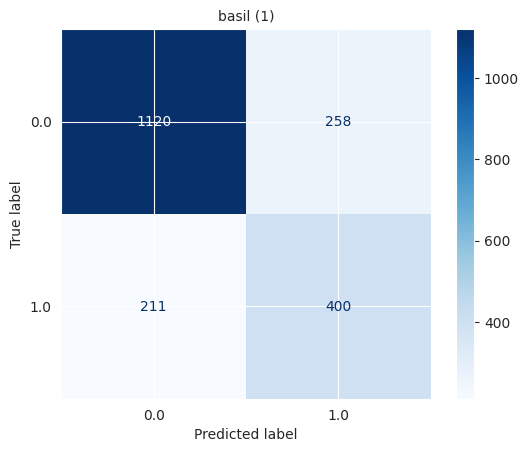

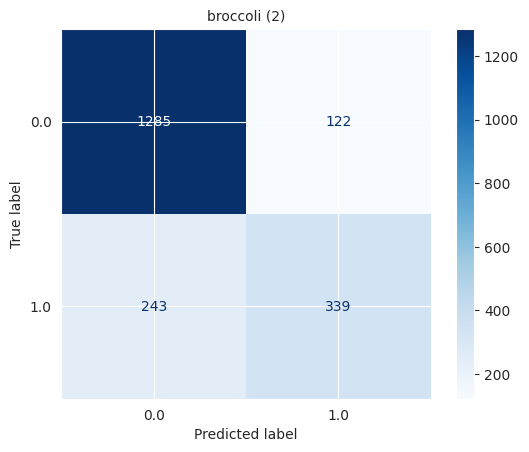

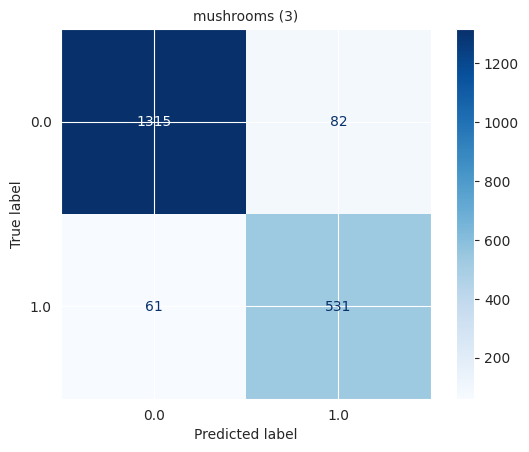

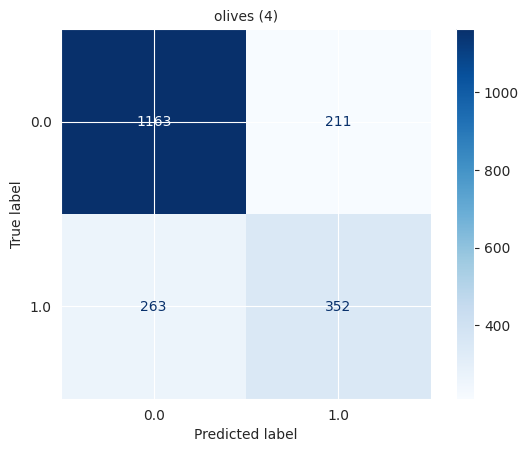

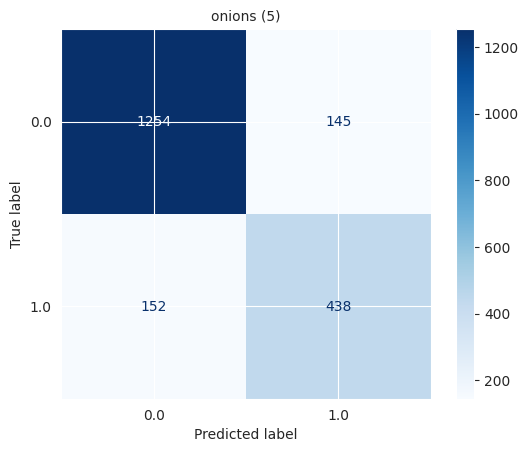

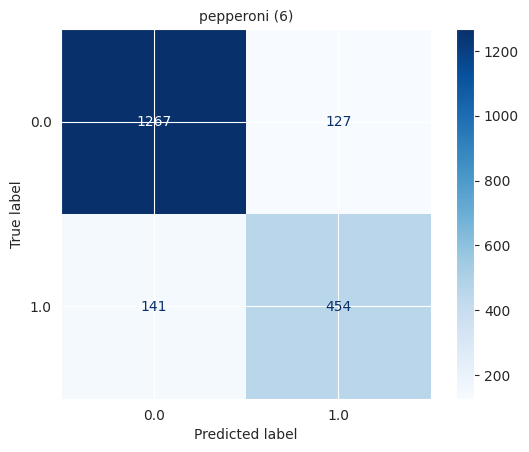

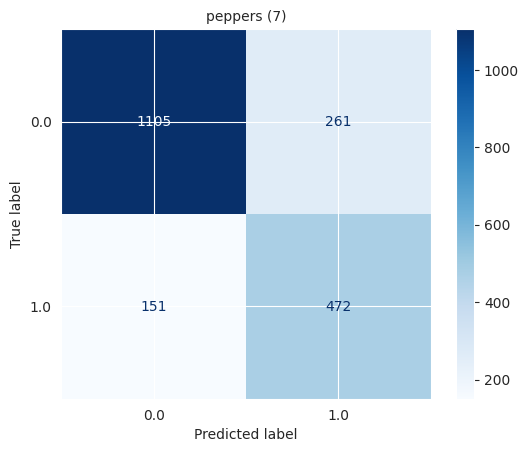

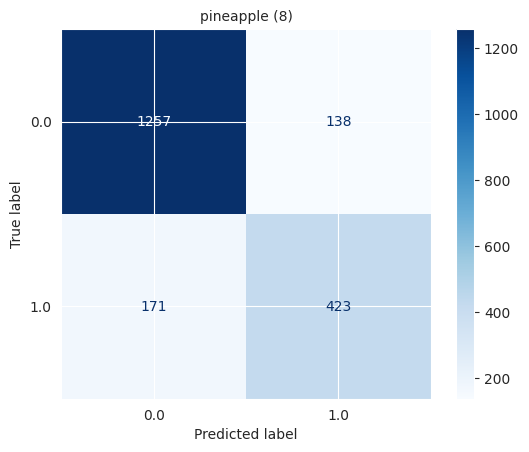

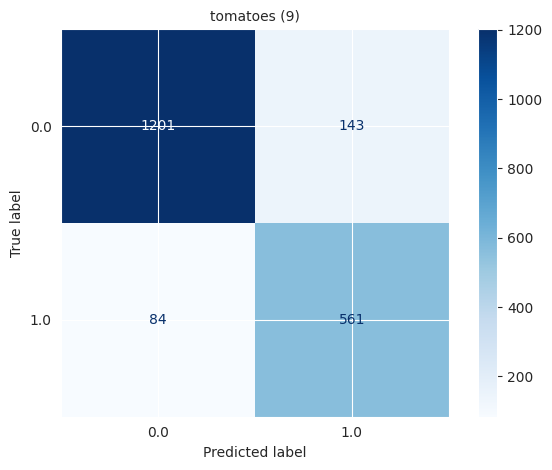

In [49]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Get multilabel confusion matrices
matrices = multilabel_confusion_matrix(y_test, y_pred)
classes = [f'{topping} ({index})' for index, topping in enumerate(topping_names)]

# Plot confusion matrix displays for each label
for i in range(len(topping_names)):
    cmd = ConfusionMatrixDisplay(matrices[i], display_labels=np.unique(y_val))
    cmd.plot(cmap='Blues')  # Use 'Blues' colormap
    plt.title(classes[i], fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

## Perceptron

In [47]:
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a base classifier
base_classifier = Perceptron(random_state=42)

# Create MultiOutputClassifier
multi_output_classifier = MultiOutputClassifier(base_classifier)

# Train the classifier
multi_output_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_output_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

# The results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)


Accuracy: 0.22
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       571
           1       0.61      0.65      0.63       611
           2       0.74      0.58      0.65       582
           3       0.87      0.90      0.88       592
           4       0.63      0.57      0.60       615
           5       0.75      0.74      0.75       590
           6       0.78      0.76      0.77       595
           7       0.64      0.76      0.70       623
           8       0.75      0.71      0.73       594
           9       0.80      0.87      0.83       645

   micro avg       0.73      0.72      0.73      6018
   macro avg       0.74      0.72      0.73      6018
weighted avg       0.74      0.72      0.73      6018
 samples avg       0.77      0.76      0.72      6018



Plotting the accuracy for each class

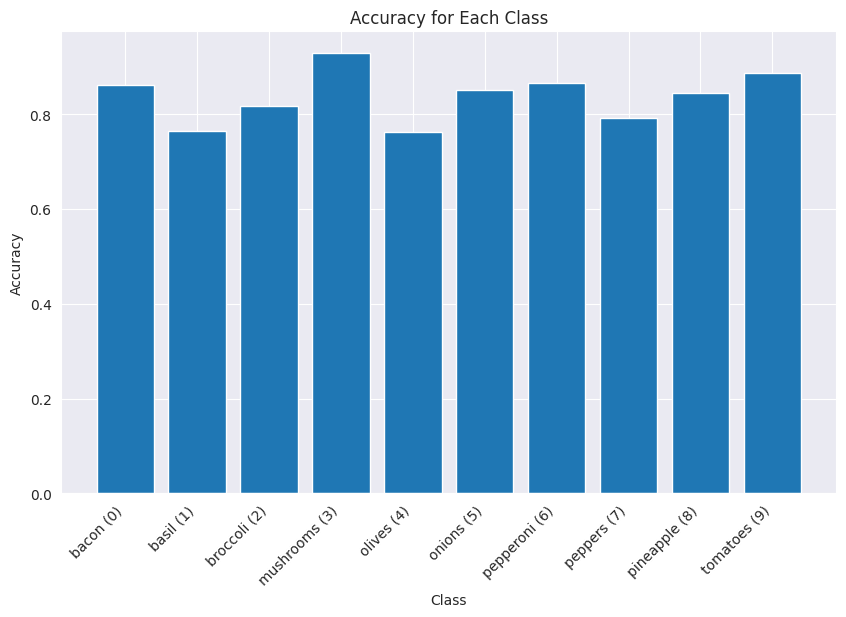

In [48]:
class_accuracy = np.mean(y_test == y_pred, axis=0)
classes = [f'{topping} ({index})' for index, topping in enumerate(topping_names)]
plt.figure(figsize=(10, 6))
plt.bar(classes, class_accuracy)
plt.title('Accuracy for Each Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(classes, rotation=45, ha="right")
plt.xticks(classes)
plt.show()

 ## Logistic Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Étape 1 : Transformation des caractéristiques polynomiales.
poly = PolynomialFeatures(2)

# Transforme les entités d'entrée en entités polynomiales jusqu'au degré 2 pour les données d'entraînement et de test
Xp_train = poly.fit_transform(X_train)
Xp_test = poly.fit_transform(X_test)

# Étape 2 : Régression logistique sans mise à l'échelle.
clf = LogisticRegression(
    random_state=0,  # Assure la reproductibilité des résultats
    max_iter=1000,  # Nombre maximum d'itérations pendant l'optimisation
    solver='liblinear',  # Algorithme utilisé pour l'optimisation (liblinear est adapté pour les petits ensembles de données)
    C=10,  # Inverse de la force de régularisation ; des valeurs plus petites spécifient une régularisation plus forte
    penalty='l2'  # Type de régularisation ('l2' pénalise l'amplitude au carré des coefficients)
)

# Entraînement du modèle de régression logistique
clf.fit(Xp_train, y_train)

# Prédiction des résultats sur l'ensemble de test
z_pred = clf.decision_function(Xp_test)

# Évaluation de l'erreur de prédiction
print("Régression logistique : L'erreur de prédiction est {:.2f}%".format(100 * (1 - clf.score(Xp_test, y_test))))

# Étape 3 : Régression logistique avec mise à l'échelle.
from sklearn import preprocessing

# Mise à l'échelle des caractéristiques polynomiales pour avoir une moyenne nulle et une variance unitaire
scaler = preprocessing.StandardScaler().fit(Xp_train)
Xp_scaled = scaler.transform(Xp_train)
Xp_test_scaled = scaler.transform(Xp_test)

# Régression logistique avec des caractéristiques mises à l'échelle.
clf = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear', C=10000, penalty='l2')
clf.fit(Xp_scaled, y_train)

# Prédiction des résultats sur l'ensemble de test avec des caractéristiques mises à l'échelle
z_pred = clf.decision_function(Xp_test_scaled)

# Évaluation de l'erreur de prédiction avec des caractéristiques mises à l'échelle
print("Régression logistique + augmentation : L'erreur de prédiction est {:.2f}%".format(100 * (1 - clf.score(Xp_test_scaled, y_test))))


In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat_resnext.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from ".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données
      img, targets = data
      # print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)



### Compute deep features for images

> Indented block



Example of how to compute deep image features. Here, we use a resnext network, but another may be as good and cheaper to compute and store.

### Learning multi-label from pre-computed features

In [ ]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat, y_all, test_size=0.2, random_state=123)

print(feat_train.shape)

# Cheсks if labels are the same as the image split
print(np.all(y_val == yfeat_val))

# Use your favorite multilabel predictor...




### Another more complex network

From torchvision.

In [ ]:
nlabel = y_all.shape[1]

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel)

# Name of the network
tag = "efficientNet"

# network = SimpleCNN(nlabel = nlabel)
# # Name of the network
# tag = "simpleCNN"


## Learning

Generic function for multi-label learning.

You have to write it!!

### Example of a code calling the learning function

In [ ]:
# Define data loaders
trainloader=train_dataloader
valloader=val_dataloader

# Read the last learned network (if stored)
if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    print('Resume from last learning step')
    network = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
#criterion = ...
#optimizer = ...
#scheduler = ...

# Learning

max_epoch = 20
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

network = learned_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)



### Final evaluation

An example of performance computation.

Again, the problem is multi-label prediction, not classification: performance metrics may be different (make a little search to find relevant ones).

In [ ]:
testloader = test_dataloader


# set the model to evaluation mode
network.eval()

# create the per
perf_label_test = np.zeros((1,nlabel))

# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in tqdm(testloader, ncols=80):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = network(inputs)

        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        # compute the predictions
        pred = (outputs_np > 0)

        # update the performance
        perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

# Prints the performance (per label)

oa_test = perf_label_test / len(testloader.dataset)
print(oa_test)